# Show results of iterative estimator

In [57]:
import numpy as np
from simulation.generate_path import generate_path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from estimation.distance_sensor import distance_sensors
from estimation.iterative_estimator import iterative_estimator
from estimation.kalman_filter_from_points import kalman_filter_from_points

# For making the plots interactive, uncomment next line:
# %matplotlib widget


In [58]:
# print the seed used
seed = np.random.randint(0, 100000)
print(seed)
np.random.seed(seed)

16210


In [59]:
# create the path

target_initial_pos = np.array([0, 0, 5000])
target_speed_xy = 50
target_speed_z = 10
target_rot_speed = 3
time_res = 0.5
sensor_sigma = 15

path1 = generate_path(0, target_speed_xy, target_speed_z, target_initial_pos, time_res)
path1.add_straight_interval(100)
path1.add_xy_turn_interval(90, -np.deg2rad(target_rot_speed))
path1.add_straight_interval(100)

In [60]:
# create noisy sensors
sensors = distance_sensors([[-5000,0,0], [400, -7400, 0], [800, 800, 0], [8000, 1000, 1000]], sensor_sigma)
sensors.calculate_measurements(path1.path)

In [61]:
# estimate the path
it_est = iterative_estimator(sensors, path1.path[0,:])
estimated_path = it_est.estimate_path()

In [62]:
# run KF on path
sigma_a = 1
sigma_v = 100
kf = kalman_filter_from_points(time_res, sigma_a, sigma_v, non_diag_reduction_ratio=2)
kf_path = kf.filter_path(estimated_path)

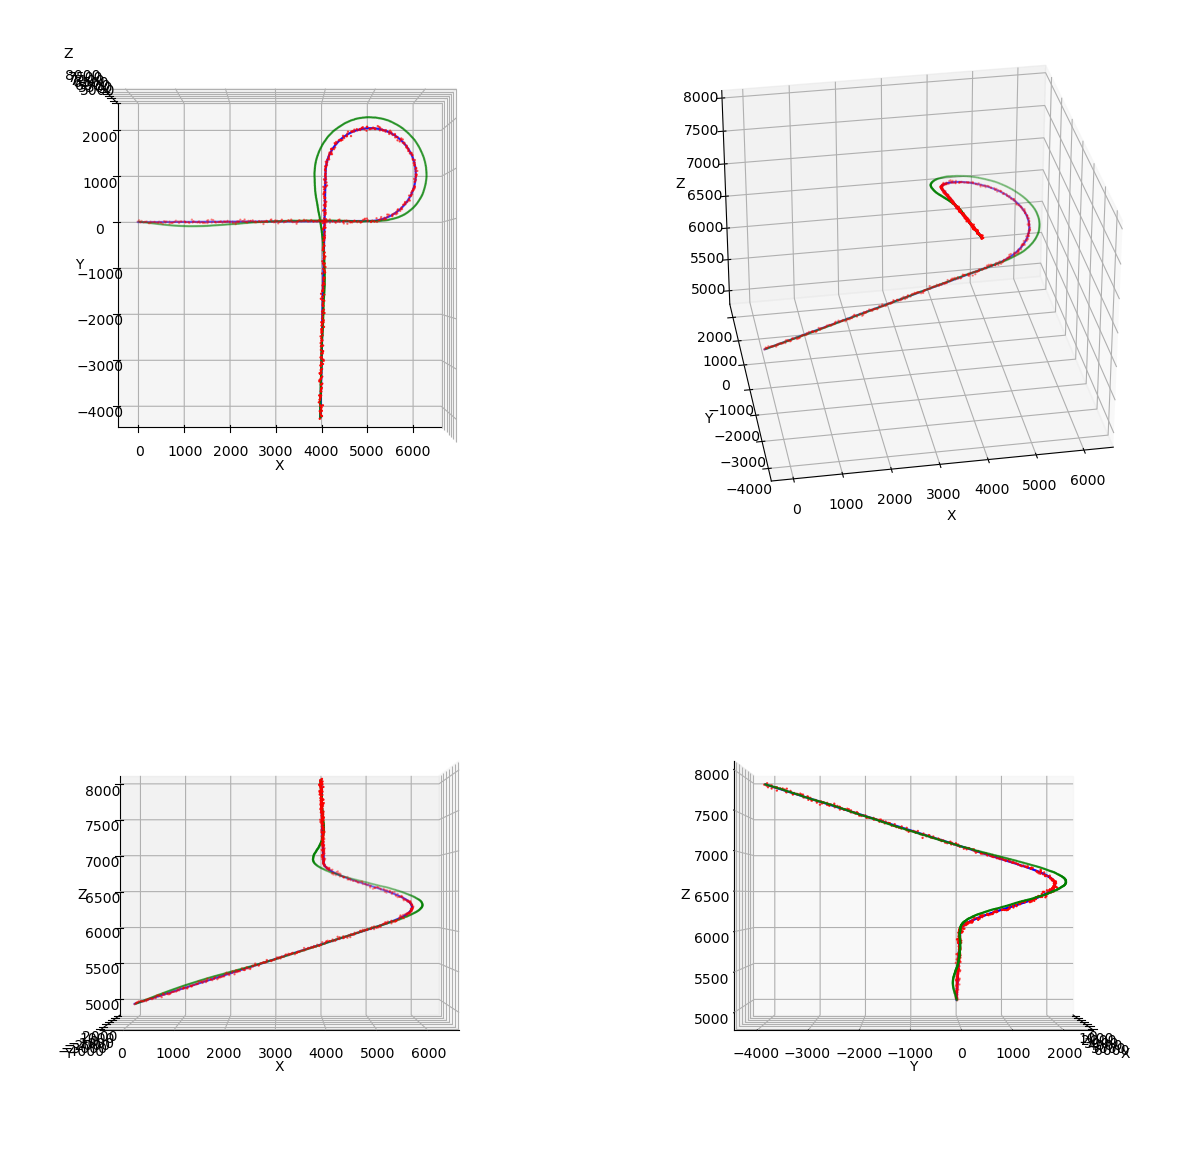

In [63]:
# Plot the path vs KF path

fig = plt.figure(figsize = (15, 15))
axes = []
views = [(90, -90), (30, -100), (0, -90), (0, 0)]
for i, view in enumerate(views):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.scatter(path1.path[:, 0], path1.path[:, 1], path1.path[:, 2], color='blue', s=0.5)
    ax.scatter(estimated_path[:, 0], estimated_path[:, 1], estimated_path[:, 2], color='red', s=0.5)
    ax.scatter(kf_path[:, 0], kf_path[:, 1], kf_path[:, 2], color='green', s=0.5)
    ax.view_init(elev=view[0], azim=view[1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

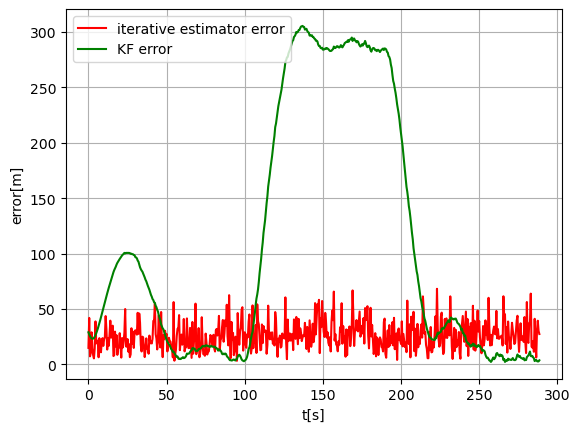

In [64]:
# show error of KF vs no KF
it_est_MSE = np.sqrt(np.sum(np.square(estimated_path-path1.path), 1))
kf_MSE = np.sqrt(np.sum(np.square(kf_path-path1.path), 1))
t = path1.time

plt.figure()
plt.plot(t, it_est_MSE, label=f'iterative estimator error', color='r')
plt.plot(t, kf_MSE, label=f'KF error', color='g')

plt.xlabel('t[s]')
plt.ylabel('error[m]')
plt.grid()
plt.legend()
plt.show()